In [3]:
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import matplotlib.pyplot as plt
import scipy.io

In [6]:
values = scipy.io.loadmat("./test2.mat")

In [7]:
percent = 0.8
p = np.random.permutation(len(values['u']))
actions = values["u"][p]
states = values['x'][p]
n = int(percent*actions.shape[0])
actions_train, actions_validate, states_train, states_validate = actions[:n], actions[n:], states[n:], states[:n]

In [8]:
states

array([[-12.33543112,  -2.03497759],
       [ 10.56303003,   8.93124055],
       [ 13.99571034,  10.44971923],
       ...,
       [ 14.08504728,   7.82793314],
       [ -5.61605586, -14.72196854],
       [  2.04366779,  11.17512364]])

In [7]:
model = keras.Sequential([
    keras.Input(shape=(2)),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(1),
])
model.build()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                48        
                                                                 
 dense_1 (Dense)             (None, 16)                272       
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 337
Trainable params: 337
Non-trainable params: 0
_________________________________________________________________


In [9]:
with tf.device('/cpu:0'):
    model.compile(optimizer=keras.optimizers.Adam(), loss="mse", metrics=["mse"])
    model.fit(states, actions, epochs=10, validation_split=0.8)

Epoch 1/10
625/625 [==============================] - 5s 8ms/step - loss: 7.9556e-04 - mse: 7.9556e-04 - val_loss: 7.0923e-04 - val_mse: 7.0923e-04
Epoch 2/10
625/625 [==============================] - 4s 7ms/step - loss: 6.2305e-04 - mse: 6.2305e-04 - val_loss: 7.6125e-04 - val_mse: 7.6125e-04
Epoch 3/10
625/625 [==============================] - 5s 8ms/step - loss: 5.1774e-04 - mse: 5.1774e-04 - val_loss: 3.6371e-04 - val_mse: 3.6371e-04
Epoch 4/10
625/625 [==============================] - 5s 8ms/step - loss: 8.2126e-04 - mse: 8.2126e-04 - val_loss: 3.5669e-04 - val_mse: 3.5669e-04
Epoch 5/10
625/625 [==============================] - 5s 8ms/step - loss: 5.4132e-04 - mse: 5.4132e-04 - val_loss: 3.4651e-04 - val_mse: 3.4651e-04
Epoch 6/10
625/625 [==============================] - 5s 8ms/step - loss: 4.2262e-04 - mse: 4.2262e-04 - val_loss: 6.4207e-04 - val_mse: 6.4207e-04
Epoch 7/10
625/625 [==============================] - 5s 8ms/step - loss: 3.9559e-04 - mse: 3.9559e-04 - val_los

In [10]:
keras.models.save_model(model, filepath="./models/mpc.tf", save_format="tf")

INFO:tensorflow:Assets written to: ./models/mpc.tf\assets


In [3]:
#http://cs229.stanford.edu/proj2013/AllenClarkStarek-MachineLearningTechniquesForOptimalSamplingBasedMotionPlanning.pdf
#Check reachability part
#Runge Kutta where?
#https://github.com/SFU-MARS/reward-shaping-ttr/blob/master/gym_foo/gym_foo/envs/DubinsCarEnv_v0.py
import numpy as np
import gym
from guaranteed_control.intervals.interval import Interval
import time
from guaranteed_control.ddpg.ddpg import train, DDPG, play
import tensorflow as tf
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

class double_integrator():

    def __init__(self, state_obj=np.array([0, 0]), cost=None):

        self.obj = state_obj
        
        self.reset()

        self.action_space = Interval(interval = [[-1, 1]])
        self.low_action, self.high_action = self.action_space.high_low()

        self.delta_t = 1
        self.min_x, self.max_x = -2, 2
        self.min_y, self.max_y = -2, 2
        self.observation_space = Interval(interval = [[-10, 10], [-10, 10]])
        self.pos_space = Interval(interval = [[self.min_x, self.max_x], [self.min_y, self.max_y]])

        self.max_iter = 50

        self.viewer = None
        self.cost = cost

        
    def step(self, action):
        done = False
        self.reward = 0

        action = np.clip(action, self.low_action, self.high_action)

        state_ = self.state

        state_[0] = state_[0] + state_[1]
        state_[1] = state_[1] + action[0]
        
        self.state = state_

        self.iteration += 1
        time.sleep(2)
        if self.iteration >= self.max_iter:
            done = True

        return self.state, self.reward, done, None

    
    def reset(self, input_interval=None):

        if input_interval == None:
            self.iteration = 0
            self.reward = 0
            self.state = np.array([0, 0])
        else:
            self.iteration = 0
            self.reward = 0
            interval = input_interval.intervals
            try:
                self.state = np.array([np.random.uniform(low = interval[0][0], high = interval[0][1]), np.random.uniform(low = interval[1][0], high = interval[1][1])])
                print(self.state)
            except RuntimeError:
                print("Bad shape for input interval, need one dimensional interval object")

        return np.array(self.state, dtype=np.float32)

        
    def render(self, mode="human"):
        screen_width = 600
        screen_height = 600

        world_width = self.max_x - self.min_x
        scale = screen_width / world_width
        car_side = 10
        car_y = 15

        if self.viewer is None:
            from gym.envs.classic_control import rendering

            self.viewer = rendering.Viewer(screen_width, screen_height)

            clearance = 10

            car = rendering.make_circle(10/2)
            # car = rendering.FilledPolygon([(-car_side/2, car_side/2), (car_side/2, car_side/2), (car_side/2, -car_side/2), -car_side/2, -car_side/2])
            # car.add_attr(rendering.Transform(translation=(0, clearance)))
            self.cartrans = rendering.Transform()
            car.add_attr(self.cartrans)
            self.cartrans.set_rotation(0)
            self.viewer.add_geom(car)

            flagx = (self.obj[0] - self.min_x) * scale
            flagy = (self.obj[1] - self.min_y) * scale
            flag_offset = (1/10) * scale
            flag = rendering.FilledPolygon(
                [(flagx+flag_offset, flagy+flag_offset), (flagx+flag_offset, flagy-flag_offset), (flagx - flag_offset, flagy-flag_offset), (flagx-flag_offset, flagy + flag_offset)]
            )
            flag.set_color(0.8, 0.8, 0)
            self.viewer.add_geom(flag)

        #This calls glRotate which implements a rotation using a rotation matrix or the rotation angle in degrees around a vector
        #RAD2DEG is dealth with in the render env
        pos_x = self.state[0]
        pos_y = 0
        self.cartrans.set_translation(
            (pos_x - self.min_x) * scale, (pos_y - self.min_y) * scale
        )
        

        return self.viewer.render(return_rgb_array=mode == "rgb_array")

    def close(self):
        if self.viewer:
            self.viewer.close()
            self.viewer = None

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
env = double_integrator()
agent = tf.keras.models.load_model("./models/mpc.tf")
eps_rewards, observations, actions = play(env, agent, n_games= 16, input_interval=Interval(interval=[[2, 2], [-2, -2]]), watch=True)

[ 2. -2.]


ValueError: Exception encountered when calling layer "sequential" (type Sequential).

Input 0 of layer "dense" is incompatible with the layer: expected min_ndim=2, found ndim=1. Full shape received: (2,)

Call arguments received:
  • inputs=tf.Tensor(shape=(2,), dtype=float32)
  • training=None
  • mask=None

In [17]:
def plot_3d(env, actor, N=1000, pendulum=False):

    try:
        high = env.observation_space.high
        low = env.observation_space.low
    except:
        print('here')
    try:
        low, high = env.observation_space.high_low()
    except:
        print('here')

    print(low, high)
    N = 500

    X, Y = np.meshgrid(np.linspace(low[0], high[0], N), np.linspace(low[1], high[1], N))

    H = np.concatenate([X.reshape((-1, 1)), Y.reshape(-1, 1)], axis=1)

    if pendulum:
        X_cos, X_sin = np.cos(H[:,0]).reshape(-1, 1), np.sin(H[:, 0]).reshape(-1, 1)
        actions = actor(np.concatenate([X_cos, X_sin, H[:,1].reshape(-1, 1)], axis=1))

    else:
        actions = actor(H)

    fig = plt.figure(figsize=(6,6))
    ax = plt.axes(projection="3d")
    ax.plot_surface(X, Y, actions.numpy().reshape(N, N))
    ax.set_xlabel('x1: position 1')
    ax.set_ylabel('x2: Position 2')
    ax.set_zlabel('z: action')

    plt.show()

here
[-10 -10] [10 10]


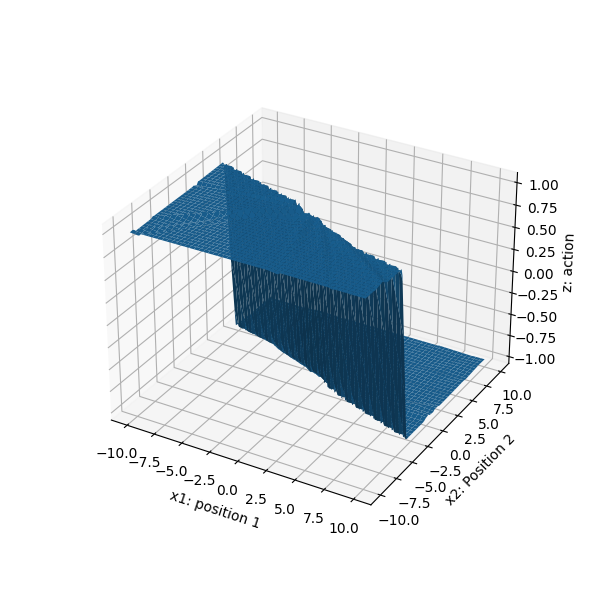

In [18]:
%matplotlib widget
plot_3d(env, agent, N=2000, pendulum=False)

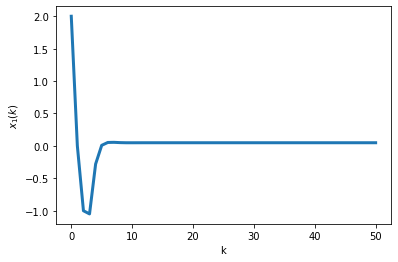

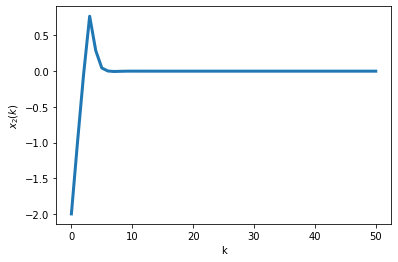

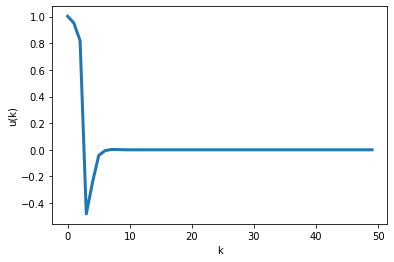

In [23]:
%matplotlib inline
plt.plot(np.array(observations[7])[:, 0], linewidth=3)
plt.ylabel(r"$x_1(k)$")
plt.xlabel("k")
plt.show()

plt.plot(np.array(observations[7])[:, 1], linewidth=3)
plt.ylabel(r"$x_2(k)$")
plt.xlabel("k")
plt.show()

plt.plot(np.array(actions[7])[:, 0], linewidth=3)
plt.xlabel("k")
plt.ylabel("u(k)")
plt.show()